# Exercise 6: AR-GARCH models

**_Group: Ducray, Razanajatovo_**

Please find below our code and empirical work regarding Apple's price returns. To fit the AR+GARCH model, we will fit first the AR(p) model and then applying the GARCH model to the residuals. The final prediction will be the sum of the ARIMA forecast + the GARCH forecasts.

In [6]:
# Dataframe, maths and plotting libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm


from statsmodels.tsa.stattools import adfuller
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

!pip install arch
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

In [7]:
#============== Load and prepare data ================

    # Import data
df = pd.read_excel('AAPL.xlsx',index_col=0)
    # Sort data in chronological order
df = df.sort_values(by='Date', ascending=True)
    # Compute the daily log returns on Apple stock prices
df_logret = np.log(df['Adj Close'].iloc[1:]).diff().dropna()*100
df_logret

Date
2018-01-04    0.463434
2018-01-05    1.132100
2018-01-08   -0.372141
2018-01-09   -0.011468
2018-01-10   -0.022950
                ...   
2022-12-15   -4.798752
2022-12-16   -1.468611
2022-12-19   -1.603751
2022-12-20   -0.052890
2022-12-21    2.353045
Name: Adj Close, Length: 1251, dtype: float64

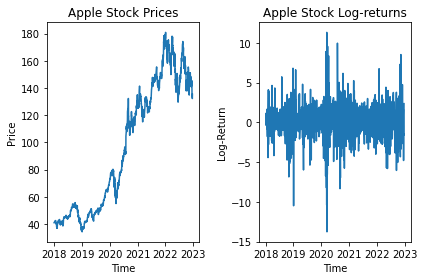

In [8]:
#================== Visual representation ===================

# Check the stock price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Adj Close'])
plt.title("Apple Stock Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_logret)
plt.title("Apple Stock Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')
plt.tight_layout()

## 1. Checking the stationarity with the Augmented Dickey Fuller test

In [9]:
test = adfuller(df_logret)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

,Output
Test Statistic Value,-11.082035
p-value,0.0
Lags Used,8
Number of Observations Used,1242
Critical Value(1%),-3.435626
Critical Value(5%),-2.86387
Critical Value(10%),-2.56801


The null hypothesis is rejected: the process is **stationary** (pvalue below thresholds & t-stat < critical value)
No need to differentiate or detrend

## 2. Fitting AR and GARCH models

Splitting dataset in train (in-sample, i.e. from 01/01/2018 to 31/08/2022) and test(out-sample, i.e. from 01/09/2022 to 21/12/2022):

In [10]:
df_train = df_logret.loc['2018-01-04':'2022-08-31' ]
df_test = df_logret.loc['2022-09-01':'2022-12-21']

### Choosing the order for AR part:

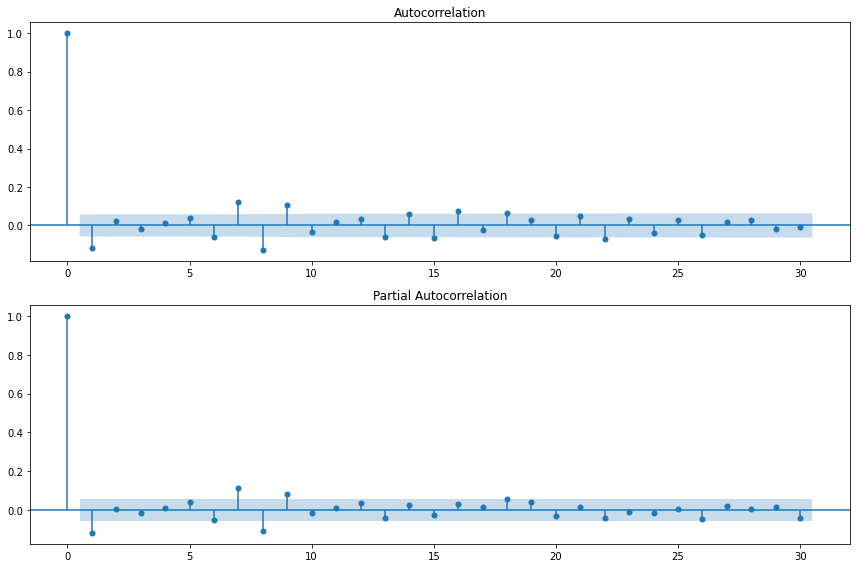

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=30, ax=ax2)
plt.tight_layout()

Graphically, we can't conclude about the exponential decay of the ACF but we can see a spike at order 1 on the PACF. We will use AIC and BIC criterion to confirm the optimal parameters:

**Paul: exponential decay or geometrical?**

In [14]:
from itertools import product
ar_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ma_order = [0]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]
#     pprint.pprint(arma_res)

for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, 0)).fit()
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 - ma:0
fitting: ar:1 - ma:0
fitting: ar:2 - ma:0
fitting: ar:3 - ma:0
fitting: ar:4 - ma:0
fitting: ar:5 - ma:0
fitting: ar:6 - ma:0
fitting: ar:7 - ma:0
fitting: ar:8 - ma:0
fitting: ar:9 - ma:0
fitting: ar:10 - ma:0
criterion
     ar_order  ma_order       aic       bic
0          0         0  5.053090  5.063224
1          1         0  5.038805  5.054007
2          2         0  5.040738  5.061007
3          3         0  5.042510  5.067846
4          4         0  5.044367  5.074771
5          5         0  5.044317  5.079789
6          6         0  5.043284  5.083823
7          7         0  5.030840  5.076446
8          8         0  5.020024  5.070697
9          9         0  5.014500  5.070241
10        10         0  5.016271  5.077079


In [15]:
#========= confirming order chosen ============
sm.tsa.arma_order_select_ic(df_train,max_ar=10,max_ma=0,ic='bic')['bic_min_order']

(1, 0)

**The order chosen is thus an AR(1) to fit the data**

### Detecting the GARCH effect:

First we construct the standardized residuals and run a normality test on them (Jarque-Bera test):

In [16]:
df_train_std = (df_train - np.mean(df_train))/ np.std(df_train)
nb_obs = len(df_train_std)

jb = sm.stats.stattools.jarque_bera(df_train_std, axis=0)
print(jb)

mw_size = 250
jb_mw = np.zeros(nb_obs-mw_size)
for x in range(0, nb_obs-mw_size):
    jb =  sm.stats.stattools.jarque_bera(df_train_std[x:mw_size+x], axis=0)  
    jb_mw [x] = jb[1]
    
np.mean(jb_mw < 0.05)

(1252.1984386754411, 1.2262073576064407e-272, -0.31921355402546586, 8.021238815322617)


0.8699891657638137

This Jarque-Bera test is a goodness-of-fit test that returns the JB t-stat, p-value, skewness and the kurtosis. Clearly **we can reject the null hypothesis of a normal distribution** (p-value being below any threshold) and confirm a GARCH effect. One could use a different distribution for GARCH, one with fatter tails and that takes into account the skewness.

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.617714216662
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53505.429787248264
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.4752996119605
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4651629840537
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.8841866466387
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158796056219
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071058190705
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.0629445302047
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.06087675463
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535437932
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.060471660766
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.0604716607586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.060471660766
            Iterations:

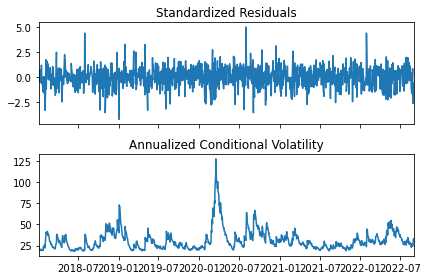

In [17]:
#======= GARCH(1,1) estimates =====================================

am = arch_model(df_train,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
# by putting o=1 you can model leverage effects => GJR-GARCH(1,1) model
res = am.fit()
print(res.summary())
fig = res.plot(annualize='D')
fig.tight_layout()

Looking at this summary, we can conclude the presence of a GARCH(1,1).

In [18]:
from scipy.stats import t
print(t.ppf(0.05,9.4548))
print(norm.ppf(0.05))

-1.8231245366836821
-1.6448536269514729


## 1-step ahead forecast:

In [19]:
idx = df_test.index
forecasts = []
data_shifted = df.shift(1).loc[idx].apply(np.log)

# estimate all
print('\nforecasting fixed')
arma_model  = tsa.arima.model.ARIMA(df_train, order=(1,0,0)).fit()
garch_res = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()

forecast_arma = arma_model.predict(n_periods=1)[0]

forecast_garch = garch_res.forecast(horizon=1, reindex=False)
predicted_et = forecast_garch.mean['h.1'].iloc[-1]

prediction = forecast_arma + predicted_et

#forecast = map(list, zip(forecast))
prediction = pd.DataFrame(prediction, columns=['fixed'], index=idx).cumsum()


forecasting fixed
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.60566980837
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.8088276138851
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.448472559479
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0807163908876
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.9852749960846
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.9396291204237
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.9326753514288
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308521666105
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306201237564
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506306682
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500117587
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500117587

In [20]:
# ============== recursive window ========================= 
print('forecasting recursive window')
forecast = []

for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    
    arma_model  = tsa.arima.model.ARIMA(_data, order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=1)[0]
    forecast_garch = garch_res.forecast(horizon=1, reindex=False)
    predicted_et = forecast_garch.mean['h.1'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())

forecast = pd.DataFrame(forecast, columns=['recursive'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting recursive window
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.617714216662
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53505.429787248264
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.4752996119605
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4651629840537
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.8841866466387
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158796056219
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071058190705
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.0629445302047
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.06087675463
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535437932
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.060471660766
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.0604716607586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.0604716

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.469523541744
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53530.82341780863
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.0613586163918
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2589.2360442809377
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2400.9612177161716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2376.1381032933723
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2375.9458284410453
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2375.9206818712287
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2375.916051058729
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2375.91529843062
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2375.914997532019
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2375.9149975320215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2375.914997532019
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6239.166393325106
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53854.07497571588
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2636.5114110525433
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2609.3278456154767
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2425.5606531795793
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2392.5763573754357
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2392.3956486209518
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2392.3739379098624
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2392.3700811788303
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2392.3694849663893
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2392.3692578959526
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2392.3692578959535
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2392.3692578959526
            Itera

Iteration:      2,   Func. Count:     17,   Neg. LLF: 54023.178896878395
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2662.600962047347
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2626.7639333762218
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2522.3008499045
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2412.2856895647783
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2412.0911379137324
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2412.068679456438
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2412.0643818100516
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2412.0637317440796
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2412.0635098558078
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2412.0635098558087
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2412.0635098558078
            Iterations: 12
            Function evaluations: 85
            Gradient evaluati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6372.929776851452
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54932.13777978051
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2688.255749243508
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2646.43743570919
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2754.546414678074
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2431.4602024798555
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2431.34691538559
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2431.3316812769945
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2431.329231747392
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2431.3287110134297
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2431.328578924764
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2431.3285783324354
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2431.3285783324354
            Iterations: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6410.901704094052
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56105.99349075122
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2705.2365868226066
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2662.3428930021573
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2586.034580898558
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2448.412693871052
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2448.30905630726
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2448.295755775464
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2448.2938239185223
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2448.2934190210194
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2448.293323946602
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2448.2933239466024
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2448.293323946602
            Iterations: 

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6478.338420771623
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55364.13076782967
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2730.406801213754
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2682.966522501588
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3637.4996029006957
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2470.9748407034594
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2470.8440312677485
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2470.8278991073594
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2470.824898339087
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2470.824338507553
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2470.824200094867
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2470.8241995310127
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2470.8241995310127
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6469.2954944443245
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55007.766364358074
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2743.72342637565
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2707.4369704130418
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3636.3460824853883
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2492.2672618416573
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2492.073270198275
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2492.0451213059623
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2492.03918744644
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2492.0382105545987
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2492.0378971164123
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2492.037896031691
Iteration:     13,   Func. Count:     90,   Neg. LLF: 2492.037896031691
Optimization terminated successfully    (Exit mode 0)
    

Iteration:     11,   Func. Count:     79,   Neg. LLF: 2511.1594577088485
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2511.159457124192
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2511.159457124192
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6530.446600982192
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55630.058195174446
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2774.7763111581685
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2728.6079957254206
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3665.807175216033
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2513.091336501839
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2512.909689968491
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2512.885144205404
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2512.88048275

Iteration:      3,   Func. Count:     26,   Neg. LLF: 2803.3799554192556
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2744.410940436135
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3684.209551889609
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2528.2237662013267
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2528.07860067986
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2528.0574186717636
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2528.0539896852683
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2528.0534011694667
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2528.05322510492
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2528.0532251049235
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2528.05322510492
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6622.352452188

In [21]:
# =================== rolling window ==================================== 
print('forecasting rolling window\n')
forecast = []
roll_freq = 200
    
for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    arma_model  = tsa.arima.model.ARIMA(_data.iloc[-roll_freq:], order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=1)[0]
    forecast_garch = garch_res.forecast(horizon=1, reindex=False)
    predicted_et = forecast_garch.mean['h.1'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())
    
forecast = pd.DataFrame(forecast, columns=['rolling'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting rolling window

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.617714216662
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53505.429787248264
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.4752996119605
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4651629840537
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.8841866466387
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158796056219
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071058190705
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.0629445302047
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.06087675463
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535437932
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.060471660766
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.0604716607586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.06047166

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.285752271022
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53612.26617588653
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.7194729482326
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2592.1270895598373
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2411.2542050168736
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2378.054726605418
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2377.8550583406127
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2377.8293684918244
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2377.824500507578
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2377.823736830681
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2377.823433476434
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2377.823433476437
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2377.823433476434
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6242.3142258467815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53619.240690649705
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2638.2725145679524
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2611.2512684468898
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2448.587778677349
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2394.0856106601473
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2393.9040222229996
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2393.8832104166377
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2393.879297003741
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2393.8786702076995
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2393.878427893289
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2393.8784278932917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2393.878427893289
            Iterati

Iteration:      8,   Func. Count:     62,   Neg. LLF: 2413.8185901448046
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2413.814425706078
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2413.8137867980013
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2413.813573893879
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2413.813573893882
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2413.813573893879
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6348.370114392085
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54083.76995541248
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2675.207719868928
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2632.173730165736
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3561.871199612451
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2417.4984204136

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6387.666015310387
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54463.33066052478
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2691.401774141902
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2652.8565222164602
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2545.665599045502
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2436.4794638915823
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2436.278867743016
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2436.255904753558
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2436.2516176507916
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2436.2510091889
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2436.2507979069223
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2436.250797906924
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2436.2507979069223
            Iterations: 1

Iteration:      8,   Func. Count:     61,   Neg. LLF: 2458.6465104563913
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2458.64310755597
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2458.6424363149144
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2458.642287530579
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2458.642286901991
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2458.642286901991
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6429.071502072134
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55971.37281655866
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2715.9021011616064
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2678.6392146404633
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3629.578439363765
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2461.926131010

Iteration:     12,   Func. Count:     85,   Neg. LLF: 2482.075736261996
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2482.0757362619875
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6453.210142162985
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55709.717685937285
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2706.3447061852207
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2631.089886967052
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3643.8568175309765
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2485.0818820968243
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2484.2479549196064
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2484.232636516183
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2484.2283597763294
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2484.22795

Iteration:     12,   Func. Count:     85,   Neg. LLF: 2500.287748114402
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2500.287748114402
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6522.638870771019
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54973.73820627653
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2767.031607868375
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2718.676694703727
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3655.9662013826164
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2503.251807301051
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2503.086771654165
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2503.0641459173357
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2503.0598495777376
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2503.059143509

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6571.728473304237
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55333.14557601477
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2795.5073441258137
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2738.187272294992
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3677.859147315741
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2522.8136973936357
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2522.6477630641525
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2522.6246967020866
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2522.62071199817
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2522.6200872762674
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2522.619895774369
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2522.6198952050736
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2522.6198952050736
            Iterations

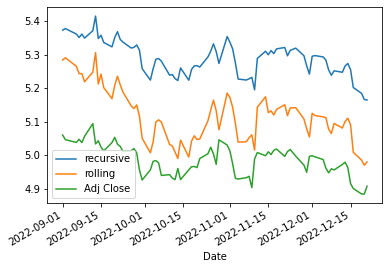


 forecasts 
             recursive   rolling
Date                           
2022-09-01   5.372622  5.283547
2022-09-02   5.377236  5.290395
2022-09-06   5.361007  5.265074
2022-09-07   5.350605  5.243247
2022-09-08   5.360835  5.243408
...               ...       ...
2022-12-15   5.255184  5.091391
2022-12-16   5.201973  5.009125
2022-12-19   5.184822  4.986387
2022-12-20   5.166402  4.970927
2022-12-21   5.165025  4.980808

[78 rows x 2 columns]

 MAE 
 recursive    2.362447
rolling      1.021278
dtype: float64

 RMSE 
 recursive    0.849381
rolling      0.390131
dtype: float64


In [22]:
#===================plot forecasts and calc error ===========================================================================    
    
forecasts = pd.concat(forecasts, axis=1)
obs = df.loc[df_test.index].apply(np.log)
# plot data and forcasts
output = pd.concat([forecasts, obs], axis=1)
output.plot()
plt.show()
# plot data and forcasts
epsilon = forecasts.sub(obs.squeeze(), axis=0)
    
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecasts)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

## 20-steps ahead forecast:

In [23]:
idx = df_test.index
forecasts = []
data_shifted = df.shift(20).loc[idx].apply(np.log)

# estimate all
print('\nforecasting fixed')
arma_model  = tsa.arima.model.ARIMA(df_train, order=(1,0,0)).fit()
garch_res = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()

forecast_arma = arma_model.predict(n_periods=20)[0]

forecast_garch = garch_res.forecast(horizon=20, reindex=False)
predicted_et = forecast_garch.mean['h.20'].iloc[-1]

prediction = forecast_arma + predicted_et

#forecast = map(list, zip(forecast))
prediction = pd.DataFrame(prediction, columns=['fixed'], index=idx).cumsum()


forecasting fixed
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.60566980837
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.8088276138851
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.448472559479
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0807163908876
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.9852749960846
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.9396291204237
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.9326753514288
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308521666105
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306201237564
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506306682
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500117587
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500117587

In [24]:
# ============== recursive window ========================= 
print('forecasting recursive window')
forecast = []

for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    
    arma_model  = tsa.arima.model.ARIMA(_data, order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=20)[0]
    forecast_garch = garch_res.forecast(horizon=20, reindex=False)
    predicted_et = forecast_garch.mean['h.20'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())

forecast = pd.DataFrame(forecast, columns=['recursive'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting recursive window
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.617714216662
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53505.429787248264
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.4752996119605
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4651629840537
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.8841866466387
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158796056219
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071058190705
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.0629445302047
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.06087675463
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535437932
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.060471660766
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.0604716607586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.0604716

Iteration:     12,   Func. Count:     85,   Neg. LLF: 2370.237229542709
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2370.2372295427185
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.469523541744
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53530.82341780863
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.0613586163918
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2589.2360442809377
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2400.9612177161716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2376.1381032933723
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2375.9458284410453
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2375.9206818712287
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2375.916051058729
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2375.91529

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6242.3142258467815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53619.240690649705
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2638.2725145679524
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2611.2512684468898
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2448.587778677349
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2394.0856106601473
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2393.9040222229996
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2393.8832104166377
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2393.879297003741
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2393.8786702076995
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2393.878427893289
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2393.8784278932917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2393.878427893289
            Iterati

Iteration:     10,   Func. Count:     74,   Neg. LLF: 2413.8137867980013
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2413.813573893879
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2413.813573893882
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2413.813573893879
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6348.370114392085
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54083.76995541248
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2675.207719868928
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2632.173730165736
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3561.871199612451
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2417.498420413651
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2417.3763646736197
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2417.3592067932

Iteration:     12,   Func. Count:     84,   Neg. LLF: 2433.0740072969425
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2433.0740072969397
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6381.106544469971
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54747.7140482409
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2689.674752645661
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2651.7955781664905
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2501.215836173194
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2434.9056125186776
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2434.7039170915564
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2434.679864245628
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2434.6755353375547
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2434.6749350

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6379.538586005714
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56087.0739409919
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2701.8457117882203
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2673.5935729152948
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2585.4951168035705
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2456.623288280587
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2456.4397341538806
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2456.417863227742
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2456.413128674824
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2456.412422951533
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2456.4122307658163
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2456.4122307658163
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2456.4122307658163
            Iterations

Iteration:      5,   Func. Count:     42,   Neg. LLF: 3638.394399828776
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2480.423576871669
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2479.7956585338684
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2479.7803596451404
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2479.7762976628574
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2479.77588122248
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2479.7758640831844
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2479.775864083198
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2479.7758640831844
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6438.256373984184
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56026.14873612895
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2705.31090280

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6491.103749530887
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54754.318877307254
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2753.2703669326474
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2712.820429711516
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3641.778508267272
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2498.1843154140743
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2498.009672102752
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2497.9824226104083
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2497.9769135222946
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2497.9758898734412
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2497.975562076762
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2497.975560878349
Iteration:     13,   Func. Count:     90,   Neg. LLF: 2497.975560878348
Optimization terminated successfully    (Exit mode 0)
    

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6555.699742873338
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55669.36135916863
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2785.016897429576
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2733.4085344613895
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3675.5628457202333
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2517.5512018451377
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2517.3775251089155
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2517.355073015489
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2517.3509677990683
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2517.3503853899297
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2517.3502129869203
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2517.3502129869253
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2517.3502129869203
            Iterati

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6642.021363069125
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55375.91971184392
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2811.8111887001896
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2757.5462226498003
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3716.8855664381667
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2537.4781436573444
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2537.2462998399087
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2537.2162089062913
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2537.210449709916
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2537.2097564772403
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2537.2095411394835
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2537.209540618381
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2537.209540618381
            Iteratio

In [25]:
# =================== rolling window ==================================== 
print('forecasting rolling window\n')
forecast = []
roll_freq = 200
    
for dt in df_test.index:
    _data = df_logret.loc[df_logret.index < dt]
    arma_model  = tsa.arima.model.ARIMA(_data.iloc[-roll_freq:], order=(1,0,0)).fit()
    garch_res = arch_model(_data,p=1, o=0, q=1, mean='AR', lags=0, dist='t').fit()
    
    forecast_arma = arma_model.predict(n_periods=20)[0]
    forecast_garch = garch_res.forecast(horizon=20, reindex=False)
    predicted_et = forecast_garch.mean['h.20'].iloc[-1]
    
    prediction = forecast_arma + predicted_et
    
    forecast.append(prediction.tolist())
    
forecast = pd.DataFrame(forecast, columns=['rolling'], index=idx)
forecasts.append(forecast.add(data_shifted.squeeze(), axis=0))

forecasting rolling window

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6120.617714216662
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53505.429787248264
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2603.4752996119605
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2575.4651629840537
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2359.8841866466387
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2356.158796056219
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2356.071058190705
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2356.0629445302047
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2356.06087675463
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2356.060535437932
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2356.060471660766
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2356.0604716607586
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2356.06047166

Iteration:      5,   Func. Count:     43,   Neg. LLF: 2400.9612177161716
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2376.1381032933723
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2375.9458284410453
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2375.9206818712287
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2375.916051058729
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2375.91529843062
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2375.914997532019
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2375.9149975320215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2375.914997532019
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6191.285752271022
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53612.26617588653
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2618.71947294

Iteration:      5,   Func. Count:     43,   Neg. LLF: 2425.5606531795793
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2392.5763573754357
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2392.3956486209518
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2392.3739379098624
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2392.3700811788303
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2392.3694849663893
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2392.3692578959526
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2392.3692578959535
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2392.3692578959526
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6242.3142258467815
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53619.240690649705
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2638.2

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6320.234657139125
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53821.22561521867
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2664.6713953230555
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2628.217085992484
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2623.8037388846647
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2414.0300349179324
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2413.839676159804
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2413.8185901448046
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2413.814425706078
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2413.8137867980013
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2413.813573893879
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2413.813573893882
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2413.813573893879
            Iterations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6381.106544469971
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54747.7140482409
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2689.674752645661
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2651.7955781664905
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2501.215836173194
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2434.9056125186776
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2434.7039170915564
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2434.679864245628
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2434.6755353375547
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2434.674935006971
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2434.6747270360765
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2434.6747270360793
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2434.6747270360765
            Iterations

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6379.538586005714
Iteration:      2,   Func. Count:     17,   Neg. LLF: 56087.0739409919
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2701.8457117882203
Iteration:      4,   Func. Count:     35,   Neg. LLF: 2673.5935729152948
Iteration:      5,   Func. Count:     43,   Neg. LLF: 2585.4951168035705
Iteration:      6,   Func. Count:     50,   Neg. LLF: 2456.623288280587
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2456.4397341538806
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2456.417863227742
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2456.413128674824
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2456.412422951533
Iteration:     11,   Func. Count:     80,   Neg. LLF: 2456.4122307658163
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2456.4122307658163
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2456.4122307658163
            Iterations

Iteration:     12,   Func. Count:     84,   Neg. LLF: 2473.88226307498
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2473.882263074981
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      7,   Neg. LLF: 6446.934261996645
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55881.23400087649
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2701.564351066827
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2627.5507603201318
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3638.394399828776
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2480.423576871669
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2479.7956585338684
Iteration:      8,   Func. Count:     62,   Neg. LLF: 2479.7803596451404
Iteration:      9,   Func. Count:     68,   Neg. LLF: 2479.7762976628574
Iteration:     10,   Func. Count:     74,   Neg. LLF: 2479.775881222

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6491.103749530887
Iteration:      2,   Func. Count:     17,   Neg. LLF: 54754.318877307254
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2753.2703669326474
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2712.820429711516
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3641.778508267272
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2498.1843154140743
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2498.009672102752
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2497.9824226104083
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2497.9769135222946
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2497.9758898734412
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2497.975562076762
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2497.975560878349
Iteration:     13,   Func. Count:     90,   Neg. LLF: 2497.975560878348
Optimization terminated successfully    (Exit mode 0)
    

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6555.699742873338
Iteration:      2,   Func. Count:     17,   Neg. LLF: 55669.36135916863
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2785.016897429576
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2733.4085344613895
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3675.5628457202333
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2517.5512018451377
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2517.3775251089155
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2517.355073015489
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2517.3509677990683
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2517.3503853899297
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2517.3502129869203
Iteration:     12,   Func. Count:     84,   Neg. LLF: 2517.3502129869253
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2517.3502129869203
            Iterati

Iteration:      2,   Func. Count:     17,   Neg. LLF: 54909.675106350085
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2807.9125793775092
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2756.226346896214
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3712.16945325872
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2535.395636739123
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2535.156511015596
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2535.1251241839495
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2535.118972948805
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2535.118232122062
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2535.117999152282
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2535.1179986113307
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2535.1179986113307
            Iterations: 12
            Function evaluations: 85
            Gradient evaluations

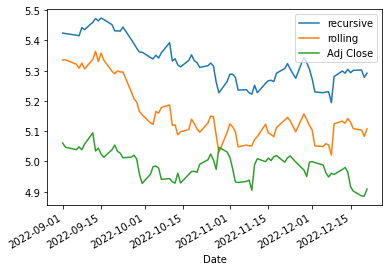


 forecasts 
             recursive   rolling
Date                           
2022-09-01   5.424430  5.335355
2022-09-02   5.422959  5.336118
2022-09-06   5.417527  5.321594
2022-09-07   5.415677  5.308319
2022-09-08   5.442553  5.325126
...               ...       ...
2022-12-15   5.293408  5.129615
2022-12-16   5.301072  5.108224
2022-12-19   5.302382  5.103947
2022-12-20   5.278092  5.082617
2022-12-21   5.291787  5.107570

[78 rows x 2 columns]

 MAE 
 recursive    2.669803
rolling      1.331938
dtype: float64

 RMSE 
 recursive    0.972026
rolling      0.518046
dtype: float64


In [19]:
#===================plot forecasts and calc error ===========================================================================    
    
forecasts = pd.concat(forecasts, axis=1)
obs = df.loc[df_test.index].apply(np.log)
# plot data and forcasts
output = pd.concat([forecasts, obs], axis=1)
output.plot()
plt.show()
# plot data and forcasts
epsilon = forecasts.sub(obs.squeeze(), axis=0)
    
mae = epsilon.abs().sum(axis=0)/10
rmse = ((epsilon**2).sum(axis=0)/10)**.5
    
print('\n forecasts \n', forecasts)
print('\n MAE \n', mae) 
print('\n RMSE \n', rmse) 

## VaR computations:

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6988.224375263742
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50688.60566980837
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2035.8088276138851
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2907.448472559479
Iteration:      5,   Func. Count:     42,   Neg. LLF: 2613.0807163908876
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1495.9852749960846
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1495.9396291204237
Iteration:      8,   Func. Count:     61,   Neg. LLF: 1495.9326753514288
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1495.9308521666105
Iteration:     10,   Func. Count:     73,   Neg. LLF: 1495.9306201237564
Iteration:     11,   Func. Count:     79,   Neg. LLF: 1495.9305506306682
Iteration:     12,   Func. Count:     85,   Neg. LLF: 1495.9305500117587
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1495.9305500117587
            Iterat

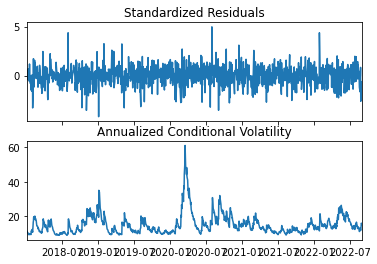

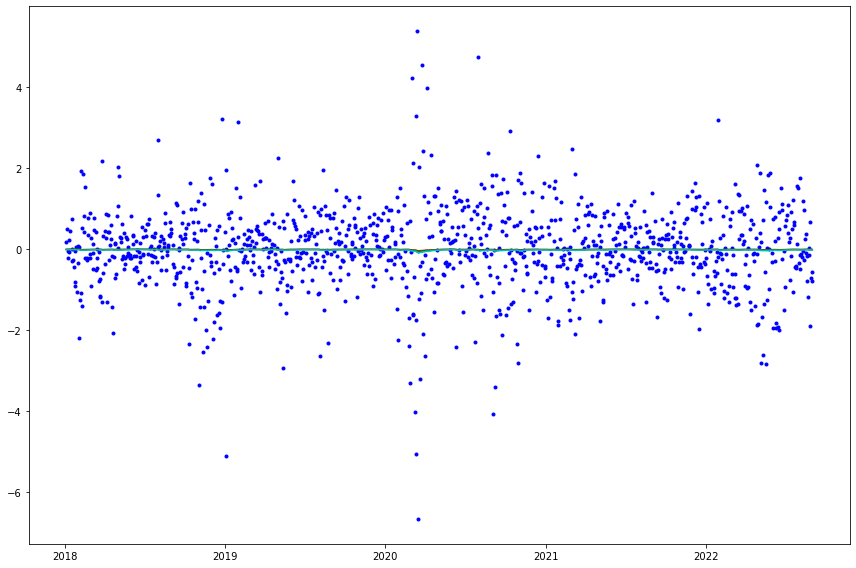

In [26]:
#================== In-sample Value-at-Risk estimates=================

#======= GARCH(1,1) estimates =====================================

am = arch_model(df_train_std,p=1, o=0, q=1, mean='AR', lags=0, dist='t') 
# by putting o=1 you can model leverage effects => GJR-GARCH(1,1) model
res = am.fit()
print(res.summary())
fig = res.plot(annualize='D')


temp = res.conditional_volatility
var90 = (0.0656 + res.conditional_volatility * t.ppf(0.10,9.2571)) /100
var95 = (0.0656 + res.conditional_volatility * t.ppf(0.05,9.2571)) /100
var99 = (0.0656 + res.conditional_volatility * t.ppf(0.01,9.2571)) /100
    
fig = plt.figure(figsize=(12,8))
plt.plot(df_train_std, 'b.', var90, 'r-', var95, 'g-', var99, 'c-')
plt.tight_layout()
 
print(np.mean(df_train_std < var90))  
print(np.mean(df_train_std < var95)) 
print(np.mean(df_train_std < var99))

In [27]:
#============= Out-of-sample Value-at-Risk estimates ===========================
alpha = 0.01

oos = 78
nb_obs = len(df_logret)

VaR_oss = pd.DataFrame(index=range(0,nb_obs), columns=['VaR_sd','VaR_GARCH','VaR_GJR','VaR_GARCHstd'])

for x in range(nb_obs-oos, nb_obs):
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_sd")] = np.std(df_test, axis=0) * norm.ppf(alpha) 
    arch_res = arch_model(df_test,p=1, o=0, q=0, dist='Normal').fit()
    arch_res_forecast = arch_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GARCH")] = np.sqrt(arch_res_forecast.variance.values[-1, 0]) * norm.ppf(alpha)
    gjr_res = arch_model(df_test,p=1, o=1, q=1, dist='Normal').fit()
    gjr_res_forecast = arch_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GJR")] = np.sqrt(gjr_res_forecast.variance.values[-1, 0]) * norm.ppf(alpha)
    garchSTD_res = arch_model(df_test,p=1, o=0, q=1, dist='t').fit()
    garchSTD_res_forecast = garchSTD_res.forecast(horizon=1)
    VaR_oss.iloc[x,VaR_oss.columns.get_loc("VaR_GARCHstd")] = np.sqrt(garchSTD_res_forecast.variance.values[-1, 0]) * t.ppf(alpha,garchSTD_res.params[-1])

Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081

Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.811799

Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 17

Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.1929547

Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 1

Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.6385

Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.88587189507672
Iteration:      6,   Func. Count:     39,   Neg. LLF: 178.8180822958301
Iteration:      7,   Func. Count:     45,   Neg. LLF: 178.75169194892257
Iteration:      8,   Func. Count:     51,   Neg. LLF: 178.72830207823083
Iteration:      9,   Func. Count:     57,   Neg. LLF: 178.71837174254603
Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1

Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081

Iteration:     10,   Func. Count:     63,   Neg. LLF: 178.7132747316166
Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 17

Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081

Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.8117996869752
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179.19295475619512
Iteration:      3,   Func. Count:     20,   Neg. LLF: 180.43183229906728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 178.98127072338082
Iteration:      5,   Func. Count:     33,   Neg. LLF: 178.885871

Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.811799

Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081

Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.619398

Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.619398

Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 

Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 1

            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 4

Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.2982

Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
         

Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.8799074

Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772864757964
Iteration:      9,   Func. Count:     59,   Neg. LLF: 176.2676732124162
Iteration:     10,   Func. Count:     64,   Neg. LLF: 176.26767340466608
Optimization terminated successfully    (Exit mode 0)
            Current function value: 176.2676732124162
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 185.811799

Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 178.5991529315816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.616476

Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.61567172518704
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      7,   Neg. LLF: 215.31081011053013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 186.29820528807113
Iteration:      3,   Func. Count:     21,   Neg. LLF: 178.63856893662424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 176.3671757178784
Iteration:      5,   Func. Count:     34,   Neg. LLF: 176.7247211411713
Iteration:      6,   Func. Count:     41,   Neg. LLF: 176.28939597939865
Iteration:      7,   Func. Count:     47,   Neg. LLF: 176.26886099423973
Iteration:      8,   Func. Count:     53,   Neg. LLF: 176.26772

Optimization terminated successfully    (Exit mode 0)
            Current function value: 178.5991523753546
            Iterations: 28
            Function evaluations: 183
            Gradient evaluations: 28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 236.4082906113731
Iteration:      2,   Func. Count:     11,   Neg. LLF: 205.87990749015196
Iteration:      3,   Func. Count:     16,   Neg. LLF: 184.2721159212002
Iteration:      4,   Func. Count:     21,   Neg. LLF: 178.76608788432077
Iteration:      5,   Func. Count:     25,   Neg. LLF: 178.63687413858645
Iteration:      6,   Func. Count:     29,   Neg. LLF: 178.61939848651443
Iteration:      7,   Func. Count:     33,   Neg. LLF: 178.61647622076447
Iteration:      8,   Func. Count:     37,   Neg. LLF: 178.6157952336772
Iteration:      9,   Func. Count:     41,   Neg. LLF: 178.61567172518704
Iteration:     10,   Func. Count:     44,   Neg. LLF: 178.61567172517564
Optimization terminated successfully    (Exit mode 0)
         

Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 178.59948345309212
Iteration:     25,   Func. Count:    154,   Neg. LLF: 178.5991647342541
Iteration:     26,   Func. Count:    160,   Neg. LLF: 178.59915427124233
Iteration:     27,   Func. Count:    166,   Neg. LLF: 178.59915427219104
Iteration:     28,   Func. Count:    173,   Neg. LLF: 

Iteration:     11,   Func. Count:     69,   Neg. LLF: 178.71131064166042
Iteration:     12,   Func. Count:     75,   Neg. LLF: 178.70090234242502
Iteration:     13,   Func. Count:     81,   Neg. LLF: 178.6850171622467
Iteration:     14,   Func. Count:     87,   Neg. LLF: 178.6550955997346
Iteration:     15,   Func. Count:     93,   Neg. LLF: 178.62658881352712
Iteration:     16,   Func. Count:     99,   Neg. LLF: 178.61456122770795
Iteration:     17,   Func. Count:    105,   Neg. LLF: 178.60952654087873
Iteration:     18,   Func. Count:    111,   Neg. LLF: 178.60525095128804
Iteration:     19,   Func. Count:    117,   Neg. LLF: 178.60188029271825
Iteration:     20,   Func. Count:    123,   Neg. LLF: 178.59994142807346
Iteration:     21,   Func. Count:    129,   Neg. LLF: 178.5993906022953
Iteration:     22,   Func. Count:    135,   Neg. LLF: 178.5992600894104
Iteration:     23,   Func. Count:    141,   Neg. LLF: 178.59920328087838
Iteration:     24,   Func. Count:    147,   Neg. LLF: 1

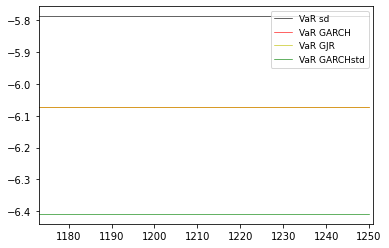

In [28]:
plt.clf()
plt.plot(VaR_oss['VaR_sd'], 'k', label='VaR sd',linewidth=0.6)
plt.plot(VaR_oss['VaR_GARCH'], 'r', label='VaR GARCH',linewidth=0.6)
plt.plot(VaR_oss['VaR_GJR'], 'y', label='VaR GJR',linewidth=0.6)
plt.plot(VaR_oss['VaR_GARCHstd'], 'g', label='VaR GARCHstd',linewidth=0.6)
plt.xlim(nb_obs-oos, nb_obs)
plt.legend(loc='best', fontsize=9)